In [1]:
# using gym==0.26.0
import tensorflow as tf

using_gpu_index = 0 # 使用的 GPU 号码
gpu_list = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpu_list[using_gpu_index],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4.75)]
    )


2023-10-16 23:52:59.940561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:52:59.960879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:52:59.961028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
from models.quantum_models import generate_circuit
import cirq
import models.quantum_genotypes as genotypes
qubits = cirq.GridQubit.rect(1, 4)
genotype = genotypes.ORI_TYPE_CP
circuit, params, inputs = generate_circuit(qubits, genotype, using_H=True)

2023-10-16 23:53:00.983162: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:53:00.984446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:53:00.984590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:53:00.984665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
from IPython.display import display, HTML
display(HTML(f"<pre>{circuit}</pre>"))

In [4]:
from models.quantum_models import generate_model_policy
from functools import reduce

env_name = "CartPole-v1"
qubits = cirq.GridQubit.rect(1, 4)
genotype = genotypes.ORI_TYPE_CP
n_actions = 2  # Number of actions in CartPole

ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)]  # Z_0*Z_1*Z_2*Z_3
# generate_model_policy(qubits, genotype, n_actions, beta, observables, env):
model = generate_model_policy(qubits, genotype, n_actions, 1., observables, env_name, using_H=True)

CartPole-v1


In [5]:
import numpy as np

state_bounds = np.array([2.4, 2.5, 0.2095, 2.5])
state_ub = state_bounds
state_lb = -1 * state_bounds

gamma = 1
batch_size = 10
n_episodes = 1000
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [6]:
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [7]:
from misc.utils import gather_episodes_, compute_returns
from datetime import datetime

start_time = datetime.now()

env_name = "CartPole-v1"

# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    # _, episodes = gather_episodes(state_ub, state_lb, n_actions, model, batch_size, env_name, backend='quafu', backend_quafu='ScQ-P10',
    #                 shots=1000,
    #                 n_qubits=4, qubits=qubits, genotype=genotype)
    _, episodes = gather_episodes_(state_ub, state_lb, n_actions, model, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, model)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break
        
end_time = datetime.now()
elapsed_time = end_time - start_time

print(f"代码执行时间：{elapsed_time}")

Finished episode 10 Average rewards:  24.6
Finished episode 20 Average rewards:  27.4
Finished episode 30 Average rewards:  26.9
Finished episode 40 Average rewards:  32.9
Finished episode 50 Average rewards:  38.9
Finished episode 60 Average rewards:  35.9
Finished episode 70 Average rewards:  77.7
Finished episode 80 Average rewards:  92.2
Finished episode 90 Average rewards:  111.4
Finished episode 100 Average rewards:  104.1
Finished episode 110 Average rewards:  124.0
Finished episode 120 Average rewards:  158.3
Finished episode 130 Average rewards:  155.5
Finished episode 140 Average rewards:  211.8
Finished episode 150 Average rewards:  261.6
Finished episode 160 Average rewards:  286.0
Finished episode 170 Average rewards:  242.9
Finished episode 180 Average rewards:  313.8
Finished episode 190 Average rewards:  391.7
Finished episode 200 Average rewards:  445.9
Finished episode 210 Average rewards:  433.5
Finished episode 220 Average rewards:  449.0
Finished episode 230 Averag

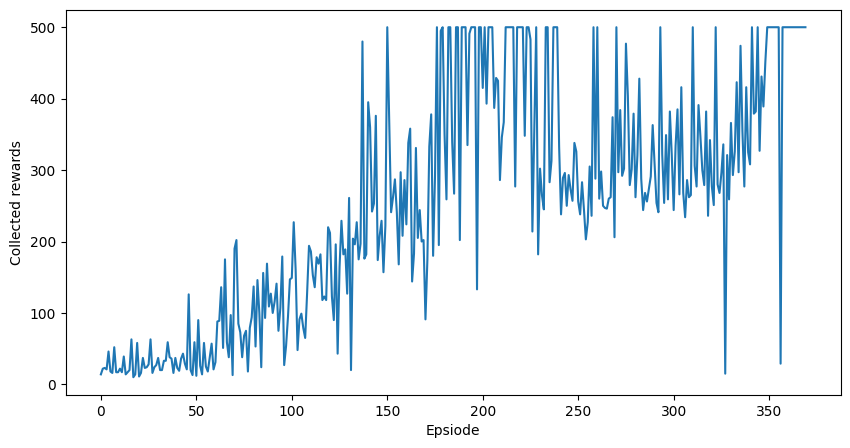

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

In [13]:
import pandas as pd

# 创建一个DataFrame对象
df = pd.DataFrame({'episode_reward_history': episode_reward_history})

# 将DataFrame保存到CSV文件
df.to_csv('../../results/example/policy_gradient/CP_episode_reward_history', index=False)  # 可以指定文件名和是否包括行索引
model.save_weights('../../weights/example/policy_gradient/PG_CP_weights.h5')